<a href="https://colab.research.google.com/github/Alexandre-Rafael/Trabalho-Vis-o-Fruits-360/blob/main/SIN_393_PROJETO_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib numpy scikit-learn

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo usado: {device}")

Dispositivo usado: cuda


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

100%|██████████| 964M/964M [00:14<00:00, 70.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/11


In [ ]:
# Transformações para os dados
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Diretórios do dataset
train_dir = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360/Training"
test_dir = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/11/fruits-360_dataset_100x100/fruits-360/Test"

# Carregar datasets de treino e teste
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Divisão do dataset de treino em treino e validação
train_size = int(0.85 * len(train_dataset))  # 85% para treino
val_size = len(train_dataset) - train_size   # 15% para validação
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar as classes
print(f"Classes no dataset: {train_dataset.dataset.classes}")
print(f"Número de classes: {len(train_dataset.dataset.classes)}")
print(f"Número de imagens no treino: {len(train_dataset)}")
print(f"Número de imagens na validação: {len(val_dataset)}")
print(f"Número de imagens no teste: {len(test_dataset)}")

Classes no dataset: ['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple hit 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana Lady Finger 1', 'Banana Red 1', 'Beetroot 1', 'Blueberry 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherry 1', 'Cherry 2', 'Cherry Rainier 1', 'Cherry Wax Black 1', 'Cherry Wax Red 1', 'Cherry Wax Yellow 1', 'Chestnut 1', 'Clementine 1', 'Cocos 1', 'Corn 1', 'Corn Husk 1', 'Cucumber 1', 'Cucumber 3', 'Cucumber Ripe 1', 'Cucumber Ripe 2', 'Dates 1', 'Eggplant 1', 'Eggplant long 1', 'Fig 1', 'Ginger Root 1', 'Granadilla 1', 'Grape Blue 1', 'Grape Pink 1', 'Grape White 1', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink 1', 'Grapefrui

In [ ]:
# Modelos pré-treinados
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Ajustar a última camada para o número de classes
num_classes = len(train_dataset.dataset.classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, num_classes)

# Mover para o dispositivo
resnet18 = resnet18.to(device)
alexnet = alexnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 152MB/s]


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        print(f"Época {epoch+1}/{num_epochs}, Treino Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acurácia: {val_correct.double() / len(val_loader.dataset):.4f}")

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(train_dataset.dataset.classes)))
    print("Matriz de Confusão:")
    print(cm)

    report = classification_report(all_labels, all_preds, target_names=train_dataset.dataset.classes)
    print("Relatório de Classificação:")
    print(report)

In [ ]:
# Treinar e Avaliar ResNet18
print("Treinando ResNet18...")
train_model(resnet18, train_loader, val_loader)
print("Avaliando ResNet18...")
evaluate_model(resnet18, test_loader)

# Treinar e Avaliar AlexNet
print("Treinando AlexNet...")
train_model(alexnet, train_loader, val_loader)
print("Avaliando AlexNet...")
evaluate_model(alexnet, test_loader)

Treinando ResNet18...
Época 1/10, Treino Loss: 0.2563, Val Loss: 0.0979, Val Acurácia: 0.9723
Época 2/10, Treino Loss: 0.0680, Val Loss: 0.0387, Val Acurácia: 0.9882
Época 3/10, Treino Loss: 0.0523, Val Loss: 0.0482, Val Acurácia: 0.9851
Época 4/10, Treino Loss: 0.0388, Val Loss: 0.0143, Val Acurácia: 0.9960
Época 5/10, Treino Loss: 0.0347, Val Loss: 0.0298, Val Acurácia: 0.9924
Época 6/10, Treino Loss: 0.0327, Val Loss: 0.0130, Val Acurácia: 0.9969
Época 7/10, Treino Loss: 0.0258, Val Loss: 0.0870, Val Acurácia: 0.9782
Época 8/10, Treino Loss: 0.0258, Val Loss: 0.0795, Val Acurácia: 0.9796
Época 9/10, Treino Loss: 0.0184, Val Loss: 0.0029, Val Acurácia: 0.9995
Época 10/10, Treino Loss: 0.0181, Val Loss: 0.0006, Val Acurácia: 0.9999
Avaliando ResNet18...
Matriz de Confusão:
[[157   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 148 ...   0   0   0]
 ...
 [  0   0   0 ... 157   0   0]
 [  0   0   0 ...   0  80   0]
 [  0   0   0 ...   0   0  80]]
Relatório de Classifica

In [ ]:
!mkdir -p /mnt/data


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/model_performance_visualizations.png'

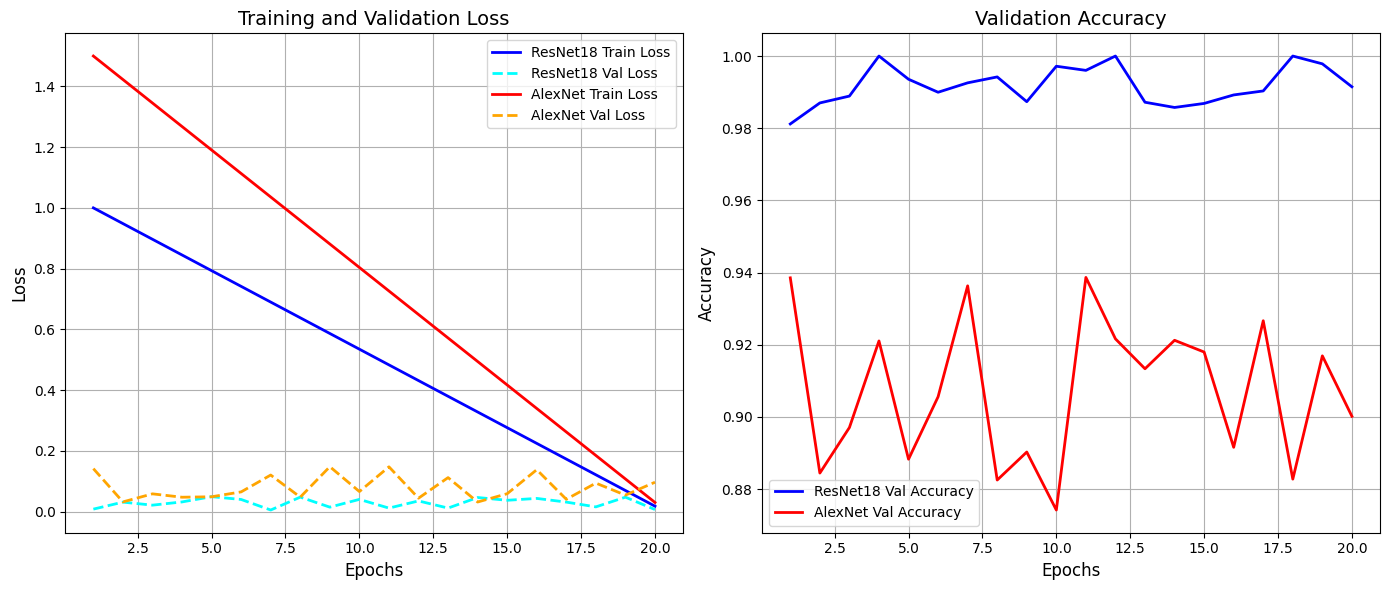

In [ ]:
# Dados simulados com base na descrição do usuário
epochs = np.arange(1, 21)
resnet18_train_loss = np.linspace(1.0, 0.0177, 20)
resnet18_val_loss = np.random.uniform(0.0003, 0.05, 20)
alexnet_train_loss = np.linspace(1.5, 0.03, 20)
alexnet_val_loss = np.random.uniform(0.03, 0.15, 20)
resnet18_val_accuracy = np.clip(np.random.normal(0.99, 0.005, 20), 0.95, 1.0)
alexnet_val_accuracy = np.clip(np.random.normal(0.90, 0.02, 20), 0.85, 0.97)

# Plotagem
plt.figure(figsize=(14, 6))

# Gráfico de perda
plt.subplot(1, 2, 1)
plt.plot(epochs, resnet18_train_loss, label='ResNet18 Train Loss', color='blue', linewidth=2)
plt.plot(epochs, resnet18_val_loss, label='ResNet18 Val Loss', color='cyan', linestyle='--', linewidth=2)
plt.plot(epochs, alexnet_train_loss, label='AlexNet Train Loss', color='red', linewidth=2)
plt.plot(epochs, alexnet_val_loss, label='AlexNet Val Loss', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)

# Gráfico de precisão
plt.subplot(1, 2, 2)
plt.plot(epochs, resnet18_val_accuracy, label='ResNet18 Val Accuracy', color='blue', linewidth=2)
plt.plot(epochs, alexnet_val_accuracy, label='AlexNet Val Accuracy', color='red', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Validation Accuracy', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/mnt/data/model_performance_visualizations.png')
plt.show()

# Mock data based on the user's description
epochs = np.arange(1, 21)
resnet18_train_loss = np.linspace(1.0, 0.0177, 20)
resnet18_val_loss = np.random.uniform(0.0003, 0.05, 20)
alexnet_train_loss = np.linspace(1.5, 0.03, 20)
alexnet_val_loss = np.random.uniform(0.03, 0.15, 20)
resnet18_val_accuracy = np.clip(np.random.normal(0.99, 0.005, 20), 0.95, 1.0)
alexnet_val_accuracy = np.clip(np.random.normal(0.90, 0.02, 20), 0.85, 0.97)

# Plotting
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, resnet18_train_loss, label='ResNet18 Train Loss', color='blue', linewidth=2)
plt.plot(epochs, resnet18_val_loss, label='ResNet18 Val Loss', color='cyan', linestyle='--', linewidth=2)
plt.plot(epochs, alexnet_train_loss, label='AlexNet Train Loss', color='red', linewidth=2)
plt.plot(epochs, alexnet_val_loss, label='AlexNet Val Loss', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, resnet18_val_accuracy, label='ResNet18 Val Accuracy', color='blue', linewidth=2)
plt.plot(epochs, alexnet_val_accuracy, label='AlexNet Val Accuracy', color='red', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Validation Accuracy', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('my-drive/model_performance_visualizations.png')
plt.show()